In [1]:
import torch
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pandas as pd
import numpy as np
import os
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

output_nums=1


# 修改后的createXY函数
def createXY(dataset: pd.DataFrame, n_past: int, n_future: int, column_target: str):
    dataX, dataY = [], []
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)
        dataY.append(dataset.iloc[i:i + n_future][column_target].values)
    return np.array(dataX), np.array(dataY)

# 修改后的process_files函数
def process_files(columns_all, column_target, folder_path, n_past=1, n_future=1):
    all_dataX, all_dataY = np.array([]), np.array([])
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            series = pd.read_csv(file_path)
            single_dataset = series[columns_all]
            dataX, dataY = createXY(single_dataset, n_past, n_future, column_target)
            all_dataX = np.vstack([all_dataX, dataX]) if all_dataX.size else dataX
            all_dataY = np.vstack([all_dataY, dataY]) if all_dataY.size else dataY
    return all_dataX, all_dataY

# 'carbohydrate','protein','fat','cellulose'
columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)','carbohydrate','protein','fat','cellulose']
# columns_all = ['CGM (mg / dl)','CSII - basal insulin (Novolin R, IU / H)']
column_target = ['CGM (mg / dl)']
folder_path = './diabetes_datasets/T1'

# 使用n_past=8, n_future=4调用process_files
n_past=8
dataX, dataY = process_files(columns_all, column_target, folder_path, n_past=n_past, n_future=output_nums)



In [3]:
dataX.shape

(15567, 8, 6)

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, optim
from torch.utils.data import Subset

# 假设dataX和dataY是你的数据
# 将它们转换为PyTorch张量，这里假设它们已经是Tensor或者从Numpy转换过来的
dataX_tensor = torch.tensor(dataX, dtype=torch.float32)
dataY_tensor = torch.tensor(dataY, dtype=torch.float32)

# 创建TensorDataset对象
dataset = TensorDataset(dataX_tensor, dataY_tensor)

# 其余拆分数据集、创建DataLoader对象的代码与之前相同
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - (train_size + val_size)


# # 随机拆分数据集
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

assert train_size + val_size + test_size == len(dataset)
# 按照顺序划分数据集
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 8
# 创建DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
feature_nums = dataX.shape[2]


In [5]:
# 修改后的GRURegressor类
class GRURegressor(nn.Module):
    def __init__(self, num_units=6, dropout=0.2, output_size=output_nums):
        super(GRURegressor, self).__init__()
        self.lstm1 = nn.GRU(input_size=feature_nums, hidden_size=num_units, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(in_features=num_units, out_features=output_size)
    
    def forward(self, X):
        X, _ = self.lstm1(X)
        X = self.dropout(X)
        X = X[:, -1, :]  # Get the last sequence output
        X = self.dense(X)
        return X

In [6]:
model = GRURegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 早停法参数
best_val_loss = float('inf')
patience = 10
patience_counter = 0
max_epochs = 5000

for epoch in range(max_epochs):
    train_loss = 0
    model.train()
    
    # Training loop
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    # 每个epoch后，在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(-1)  # 调整目标尺寸
            output = model(data)
            val_loss += criterion(output, target).item()
    
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print(f'Epoch {epoch}: Training Loss: {train_loss}, Validation Loss: {val_loss}')

    # 早停法逻辑
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最好的模型状态
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        model.load_state_dict(best_model_state)
        break



Epoch 0: Training Loss: 31412.681994294468, Validation Loss: 27595.588141651642
Epoch 1: Training Loss: 29294.903088452065, Validation Loss: 25235.625955747946
Epoch 2: Training Loss: 26684.891846225688, Validation Loss: 23122.67252306816
Epoch 3: Training Loss: 24610.112432310027, Validation Loss: 21281.5723540086
Epoch 4: Training Loss: 22743.19884266592, Validation Loss: 19587.41672492394
Epoch 5: Training Loss: 20958.205519855837, Validation Loss: 18011.63573850974
Epoch 6: Training Loss: 19354.776621192286, Validation Loss: 16556.231520283833
Epoch 7: Training Loss: 17815.179887933275, Validation Loss: 15209.461390165183
Epoch 8: Training Loss: 16407.31013341309, Validation Loss: 13965.995031833649
Epoch 9: Training Loss: 15137.16407519824, Validation Loss: 12824.533594000033
Epoch 10: Training Loss: 13882.174878438858, Validation Loss: 11772.674247670784
Epoch 11: Training Loss: 12839.215384545392, Validation Loss: 10811.347569158444
Epoch 12: Training Loss: 11849.775305148672, V

In [7]:
# 加载最佳模型状态
model.load_state_dict(best_model_state)

# 在测试集上验证模型并输出预测标签
model.eval()
test_loss = 0
all_predictions = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze(-1)  # 调整目标尺寸
        output = model(data)
        test_loss += criterion(output, target).item()
        all_predictions.append(output.cpu().numpy())
        all_targets.append(target.cpu().numpy())

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss}')

# 将预测标签和真实标签拼接成一个数组
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

all_predictions = all_predictions.reshape(-1)
all_targets = all_targets.reshape(-1)
all_predictions.shape, all_targets.shape


Test Loss: 405.5007709454267


((3114,), (3114,))

In [8]:
import torch

# 保存模型的状态字典到文件
torch.save(model.state_dict(), './model/gru.pth')


### 取了最后1000个，可以取最后500-1000个观察一下，我这里发现是在峰值和低谷的时候预测都会差一点，是不是要考虑时间特征，这个我做个case study研究研究。

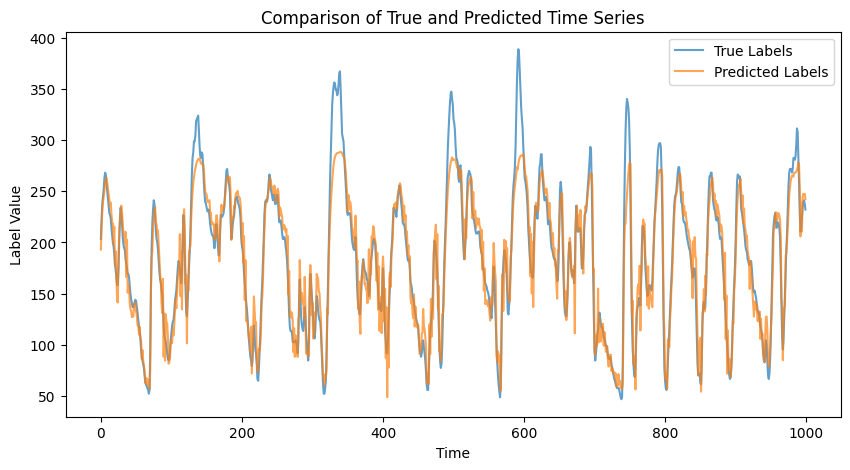

In [9]:
import matplotlib.pyplot as plt

# 画出比对图
plt.figure(figsize=(10, 5))
plt.plot(all_targets[-1000:], label='True Labels', alpha=0.7)
plt.plot(all_predictions[-1000:], label='Predicted Labels', alpha=0.7)
plt.legend()
plt.title('Comparison of True and Predicted Time Series')
plt.xlabel('Time')
plt.ylabel('Label Value')
plt.show()

In [10]:
targets_case=all_targets[-1000:]
predictions_case=all_predictions[-1000:]

# 找到同一位置，两者相差50以上的targets_case的值与位置
indexs = []
for i in range(len(targets_case)):
    if abs(targets_case[i]-predictions_case[i])>40:
        indexs.append(i)
        print(i,targets_case[i],predictions_case[i])


135 318.6 275.52234
136 320.4 278.5231
137 322.2 280.1671
138 324.0 281.25635
267 129.6 172.15045
325 262.8 222.72583
326 288.0 237.38873
327 311.4 249.5882
328 334.8 260.4232
329 345.6 269.1894
330 352.8 275.9342
331 356.4 280.58502
332 354.6 283.68094
333 349.2 285.5973
334 349.2 286.60855
335 343.8 287.31073
336 345.6 287.4851
337 354.6 287.5947
338 365.4 287.88995
339 367.2 288.3085
340 349.2 288.5717
380 147.6 193.2395
403 113.4 154.72433
405 91.8 136.95567
406 91.8 48.848213
408 126.0 77.691666
492 293.4 250.70432
493 309.6 260.18762
494 324.0 267.58157
495 336.6 273.29248
496 345.6 277.58334
497 347.4 280.85074
498 340.2 283.16898
499 334.8 280.59543
560 120.6 161.64084
571 185.4 133.46024
589 324.0 267.63324
590 358.2 273.68463
591 379.8 271.3502
592 388.8 277.02722
593 383.4 280.73297
594 365.4 283.2331
595 345.6 284.594
596 331.2 285.04712
672 172.8 111.250305
697 212.4 252.63995
699 126.0 174.07828
743 275.4 216.99277
744 309.6 218.36642
745 331.2 235.28656
746 340.2 247.329